# Goal

Accuracy as a function of isotope incorporation

### Variable parameters:

* atom % isotope incorporation
  * 0, 25, 50, 100
* % taxa that incorporate
  * __1, 5, 10, 25, 50__
* n-reps (stocastic: taxon abundances & which incorporate)
  * 10 

# Setting paths

In [138]:
# paths
import os

workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/'
buildDir = os.path.join(workDir, 'atomIncorp_taxaIncorp')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags_kde.pkl'
genome_index = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

## Init

In [139]:
import glob
import itertools
import nestly

In [140]:
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [141]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [142]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)
%cd $buildDir

/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp


### BD min/max

In [143]:
## min G+C cutoff
min_GC = 13.5
## max G+C cutoff
max_GC = 80
## max G+C shift
max_13C_shift_in_BD = 0.036


min_BD = min_GC/100.0 * 0.098 + 1.66    
max_BD = max_GC/100.0 * 0.098 + 1.66    

max_BD = max_BD + max_13C_shift_in_BD

print 'Min BD: {}'.format(min_BD)
print 'Max BD: {}'.format(max_BD)

Min BD: 1.67323
Max BD: 1.7744


# Nestly

* assuming fragments already simulated

In [144]:
# making an experimental design file for qSIP
x = range(1,7)
y = ['control', 'treatment']

expDesignFile = os.path.join(buildDir, 'qSIP_exp_design.txt')
with open(expDesignFile, 'wb') as outFH:
    for i,z in itertools.izip(x,itertools.cycle(y)):
        line = '\t'.join([str(i),z])
        outFH.write(line + '\n')

!head $expDesignFile       

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment


## Nestly params

In [170]:
# building tree structure
nest = nestly.Nest()

# varying params: test
#nest.add('percIncorp', [100])
#nest.add('percTaxa', [10])
#nest.add('rep', range(1,4))

# varying params
nest.add('percIncorp', [0, 15, 25, 50, 100])
nest.add('percTaxa', [1, 5, 10, 25, 50])
nest.add('rep', range(1,11))

## set params
nest.add('abs', ['1e9'], create_dir=False)
nest.add('np', [10], create_dir=False)
nest.add('Monte_rep', [100000], create_dir=False)
nest.add('subsample_dist', ['lognormal'], create_dir=False)
nest.add('subsample_mean', [9.432], create_dir=False)
nest.add('subsample_scale', [0.5], create_dir=False)
nest.add('subsample_min', [10000], create_dir=False)
nest.add('subsample_max', [30000], create_dir=False)
nest.add('min_BD', [min_BD], create_dir=False)
nest.add('max_BD', [max_BD], create_dir=False)
nest.add('DBL_scaling', [0.5], create_dir=False)
nest.add('bandwidth', [0.8], create_dir=False)
nest.add('heavy_BD_min', [1.71], create_dir=False)
nest.add('heavy_BD_max', [1.75], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)

### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('genome_index', [genome_index], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('exp_design', [expDesignFile], create_dir=False)


# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

## Experimental design

In [179]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_expDesign.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_expDesign.sh'

In [180]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- Experimental design --#'

echo '# Making an isotope incorporation config file'
echo '## 3 replicate gradients for control & treatment'
SIPSim incorpConfigExample \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > incorp.config

echo '# Selecting incorporator taxa'
echo '## This is to make the gradient replicates consistent (qSIP finds mean among replicates)'
SIPSim KDE_selectTaxa \
    -p {percTaxa} \
    {fragFile} \
    > incorporators.txt

echo '# Creating a community file (3 replicate control, 3 replicate treatment)'
SIPSim communities \
    --config incorp.config \
    {genome_index} \
    > comm.txt    

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    --BD_min {min_BD} \
    --BD_max {max_BD} \
    comm.txt \
    > fracs.txt        

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_expDesign.sh


In [51]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file exp_design.log -j 10

2016-03-28 06:59:24,041 * INFO * Template: ./SIPSimRun.sh
2016-03-28 06:59:24,043 * INFO * [145094] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/7
2016-03-28 06:59:24,044 * INFO * [145095] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/9
2016-03-28 06:59:24,045 * INFO * [145097] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/8
2016-03-28 06:59:24,047 * INFO * [145099] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/3
2016-03-28 06:59:24,048 * INFO * [145101] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/10
2016-03-28 06:59:24,050 * INFO * [145103] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/2
2016-03-28 06:59:24,052 * INFO * [145105] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/1
2016-03-28 06:59:24,054 * INFO * [145107] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/4
2016-03-28 06:59:24,056 * INFO * [145109] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/5
2016-03-28 06:59:24,058 * INFO * [145111] Started ./SIPSimR

In [52]:
%pushnote exp_design complete: $buildDir

## SIPSim pipeline

In [182]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-pipeline.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-pipeline.sh'

In [183]:
%%writefile $bashFileTmp
#!/bin/bash

echo '#-- SIPSim pipeline --#'    
    
echo '# Adding diffusion'    
SIPSim diffusion \
    -n {Monte_rep} \
    --bw {bandwidth} \
    --np {np} \
    {fragFile} \
    > ampFrags_KDE_dif.pkl    

echo '# Adding DBL contamination; abundance-weighted smearing'
SIPSim DBL \
    -n {Monte_rep} \
    --comm comm.txt \
    --commx {DBL_scaling} \
    --np {np} \
    ampFrags_KDE_dif.pkl \
    > ampFrags_KDE_dif_DBL.pkl 

echo '# Adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    -n {Monte_rep} \
    --comm comm.txt \
    --taxa incorporators.txt \
    --np {np} \
    ampFrags_KDE_dif_DBL.pkl \
    incorp.config \
    > ampFrags_KDE_dif_DBL_inc.pkl

echo '# Simulating an OTU table'
SIPSim OTU_table \
    --abs {abs} \
    --np {np} \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    > OTU_abs{abs}.txt
    
echo '# Simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# Subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    --dist {subsample_dist} \
    --dist_params mean:{subsample_mean},sigma:{subsample_scale} \
    --min_size {subsample_min} \
    --max_size {subsample_max} \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# Making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# Making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
       

#-- removing large intermediate files --#
rm -f ampFrags_KDE_dif.pkl
rm -f ampFrags_KDE_dif_DBL.pkl
rm -f ampFrags_KDE_dif_DBL_inc.pkl    

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-pipeline.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_pipeline.log -j 2

2016-03-28 07:01:04,305 * INFO * Template: ./SIPSimRun.sh
2016-03-28 07:01:04,307 * INFO * [167960] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/7
2016-03-28 07:01:04,308 * INFO * [167961] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/9
2016-03-28 07:32:58,553 * INFO * [167961] atomIncorp_taxaIncorp/50/50/9 Finished with 0
2016-03-28 07:32:58,631 * INFO * [168813] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/8
2016-03-28 07:38:10,926 * INFO * [167960] atomIncorp_taxaIncorp/50/50/7 Finished with 0
2016-03-28 07:38:10,952 * INFO * [169053] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/3
2016-03-28 08:06:02,932 * INFO * [168813] atomIncorp_taxaIncorp/50/50/8 Finished with 0
2016-03-28 08:06:02,954 * INFO * [170001] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/10
2016-03-28 08:08:42,327 * INFO * [169053] atomIncorp_taxaIncorp/50/50/3 Finished with 0
2016-03-28 08:08:42,345 * INFO * [170196] Started ./SIPSimRun.sh in atomIncorp_taxaIncorp/50/50/2
2

In [ ]:
%pushnote SIPSim pipeline complete: $buildDir

## Summary of simulated data

In [198]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_SIPSim-summary.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-summary.sh'

In [199]:
%%writefile $bashFileTmp
#!/bin/bash
   
# plotting 'raw' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}

# plotting 'sequenced' taxon abundances
SIPSimR OTU_taxonAbund \
    OTU_abs{abs}_PCR_sub.txt \
    -r {topTaxaToPlot} \
    -o OTU_abs{abs}_PCR_sub

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_SIPSim-summary.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file SIPSim_summary.log -j 10

## HR-SIP: DESeq2

In [176]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_HRSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_HRSIP.sh'

In [177]:
%%writefile $bashFileTmp
#!/bin/bash

# phyloseq
## making phyloseq object from OTU table
SIPSimR phyloseq_make \
    OTU_abs{abs}_PCR_sub_w.txt \
    -s OTU_abs{abs}_PCR_sub_meta.txt \
    > OTU_abs{abs}_PCR_sub.physeq

## filtering phyloseq object to just 'heavy' fractions
SIPSimR phyloseq_edit \
    OTU_abs{abs}_PCR_sub.physeq \
    --BD_min {heavy_BD_min} \
    --BD_max {heavy_BD_max} \
    > OTU_abs{abs}_PCR_sub_filt.physeq

## making ordination
SIPSimR phyloseq_ordination \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    OTU_abs{abs}_PCR_sub_filt_bray-NMDS.pdf

# DESeq2
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    OTU_abs{abs}_PCR_sub_filt.physeq \
    > OTU_abs{abs}_PCR_sub_filt_DESeq2

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_HRSIP.sh


In [178]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file HR-SIP.log -j 14

2016-05-15 09:40:23,227 * INFO * Template: ./SIPSimRun_HRSIP.sh
2016-05-15 09:40:23,247 * INFO * [22025] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-05-15 09:40:23,268 * INFO * [22027] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9
2016-05-15 09:40:23,269 * INFO * [22028] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/8
2016-05-15 09:40:23,271 * INFO * [22030] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/3
2016-05-15 09:40:23,274 * INFO * [22032] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/10
2016-05-15 09:40:23,297 * INFO * [22035] Started ./SIPSimRun_HRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/2
2016-05-15 09:40:23,299 * INFO * [22036] 

In [179]:
%pushnote HR-SIP complete: $buildDir

## MW-HR-SIP

* BD windows: 1.70-1.73,1.72-1.75,1.74-1.77

In [161]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_MWHRSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_MWHRSIP.sh'

In [162]:
%%writefile $bashFileTmp
#!/bin/bash

## HR SIP pipeline
SIPSimR phyloseq_DESeq2 \
    --log2 {log2} \
    --hypo greater \
    --cont 1,3,5 \
    --treat 2,4,6 \
    --occur_all 0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5 \
    -w 1.70-1.73,1.72-1.75,1.74-1.77 \
    --all OTU_abs1e9_PCR_sub_MW-all.txt \
    OTU_abs{abs}_PCR_sub.physeq \
    > OTU_abs{abs}_PCR_sub_filt_MW_DESeq2

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_MWHRSIP.sh


In [163]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file MW-HR-SIP.log -j 14

2016-05-15 08:34:42,203 * INFO * Template: ./SIPSimRun_MWHRSIP.sh
2016-05-15 08:34:42,225 * INFO * [195697] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-05-15 08:34:42,227 * INFO * [195698] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9
2016-05-15 08:34:42,231 * INFO * [195700] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/8
2016-05-15 08:34:42,235 * INFO * [195702] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/3
2016-05-15 08:34:42,239 * INFO * [195704] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/10
2016-05-15 08:34:42,243 * INFO * [195706] Started ./SIPSimRun_MWHRSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/2
2016-05-15 08:34:42,2

In [164]:
%pushnote MW-HR-SIP complete: $buildDir

## qSIP

In [105]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_qSIP.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_qSIP.sh'

In [106]:
%%writefile $bashFileTmp
#!/bin/bash


# qSIP
SIPSim qSIP \
    OTU_abs{abs}.txt \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_qSIP.txt
        

# qSIP: atom excess
SIPSim qSIP_atomExcess \
    --np {np} \
    OTU_abs{abs}_PCR_sub_qSIP.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_qSIP_atom.txt  

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_qSIP.sh


In [ ]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file qSIP.log -j 2

2016-04-07 13:06:21,844 * INFO * Template: ./SIPSimRun_qSIP.sh
2016-04-07 13:06:21,867 * INFO * [116857] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-04-07 13:06:21,874 * INFO * [116859] Started ./SIPSimRun_qSIP.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9


In [ ]:
%pushnote qSIP complete: $buildDir

## deltaBD

In [86]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_dBD.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_dBD.sh'

In [87]:
%%writefile $bashFileTmp
#!/bin/bash

#deltaBD 
SIPSim deltaBD \
    OTU_abs{abs}_PCR_sub.txt \
    {exp_design} \
    > OTU_abs{abs}_PCR_sub_dBD.txt  

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_dBD.sh


In [89]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file deltaBD.log -j 10

2016-04-26 11:44:36,592 * INFO * Template: ./SIPSimRun_dBD.sh
2016-04-26 11:44:36,594 * INFO * [223246] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-04-26 11:44:36,596 * INFO * [223247] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9
2016-04-26 11:44:36,599 * INFO * [223249] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/8
2016-04-26 11:44:36,603 * INFO * [223251] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/3
2016-04-26 11:44:36,606 * INFO * [223253] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/10
2016-04-26 11:44:36,608 * INFO * [223256] Started ./SIPSimRun_dBD.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/2
2016-04-26 11:44:36,610 * INFO * [223257] Started

In [90]:
%pushnote deltaBD complete: $buildDir

## Making confusion matrices

In [185]:
bashFileTmp = os.path.splitext(bashFile)[0] + '_cMtx.sh'
bashFileTmp

'/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_cMtx.sh'

In [186]:
%%writefile $bashFileTmp
#!/bin/bash

# HR-SIP
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_DESeq2

# HR-SIP multiple 'heavy' BD windows
SIPSimR DESeq2_confuseMtx \
    --libs 2,4,6 \
    --padj {padj} \
    -o DESeq2_multi-cMtx \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_filt_MW_DESeq2
    
# qSIP    
SIPSimR qSIP_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub_qSIP_atom.txt

# heavy-SIP    
SIPSimR heavy_confuseMtx \
    --libs 2,4,6 \
    BD-shift_stats.txt \
    OTU_abs{abs}_PCR_sub.txt

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/SIPSimRun_cMtx.sh


In [187]:
!chmod 777 $bashFileTmp
!cd $workDir; \
    nestrun --template-file $bashFileTmp -d $buildDir --log-file cMtx.log -j 14

2016-05-15 10:01:55,408 * INFO * Template: ./SIPSimRun_cMtx.sh
2016-05-15 10:01:55,410 * INFO * [113052] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/7
2016-05-15 10:01:55,412 * INFO * [113053] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/9
2016-05-15 10:01:55,414 * INFO * [113055] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/8
2016-05-15 10:01:55,415 * INFO * [113057] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/3
2016-05-15 10:01:55,417 * INFO * [113059] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/10
2016-05-15 10:01:55,419 * INFO * [113061] Started ./SIPSimRun_cMtx.sh in /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/50/50/2
2016-05-15 10:01:55,420 * INFO * [113063] 

### Aggregating the confusion matrix data

In [188]:
def agg_cMtx(prefix):
    # all data
    #!nestagg delim \
    #    -d $buildDir \
    #    -k percIncorp,percTaxa,rep \
    #    -o $prefix-cMtx_data.txt \
    #    --tab \
    #    $prefix-cMtx_data.txt

    # overall
    x = prefix + '-cMtx_overall.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x

    # by class
    x = prefix + '-cMtx_byClass.txt'
    !nestagg delim \
        -d $buildDir \
        -k percIncorp,percTaxa,rep \
        -o $x \
        --tab \
        $x
        
agg_cMtx('DESeq2')
agg_cMtx('DESeq2_multi')
agg_cMtx('qSIP') 
agg_cMtx('heavy') 

In [189]:
%pushnote atomIncorp_taxaIncorp complete!

***
# --End of simulation--#
***

# Plotting results

In [190]:
F = os.path.join(buildDir, '*-cMtx_byClass.txt')
files = glob.glob(F)
files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/DESeq2-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/qSIP-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/heavy-cMtx_byClass.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/DESeq2_multi-cMtx_byClass.txt']

In [191]:
%%R -i files

df_byClass = list()
for (f in files){
    ff = strsplit(f, '/') %>% unlist
    fff = ff[length(ff)]
    df_byClass[[fff]] = read.delim(f, sep='\t')
}

df_byClass = do.call(rbind, df_byClass)
df_byClass$file = gsub('\\.[0-9]+$', '', rownames(df_byClass))
df_byClass$method = gsub('-.+', '', df_byClass$file)
rownames(df_byClass) = 1:nrow(df_byClass)

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.2805755         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                     file method
1 DESeq2-cMtx_byClass.txt DESeq2
2 DESeq2-cMtx_byClass.txt DESeq2
3 DESeq2-cMtx_byClass.txt DESeq2


In [192]:
%%R
# renaming method
rename = data.frame(method = c('DESeq2', 'DESeq2_multi', 'heavy', 'qSIP'), 
                   method_new = c('HR-SIP', 'MW-HR-SIP', 'Heavy-SIP', 'qSIP'))

df_byClass = inner_join(df_byClass, rename, c('method'='method')) %>%
    select(-method) %>%
    rename('method' = method_new) 

df_byClass %>% head(n=3)

  library      variables    values percIncorp percTaxa rep
1       2    Sensitivity 0.2805755         50       50   7
2       2    Specificity 1.0000000         50       50   7
3       2 Pos Pred Value 1.0000000         50       50   7
                     file method
1 DESeq2-cMtx_byClass.txt HR-SIP
2 DESeq2-cMtx_byClass.txt HR-SIP
3 DESeq2-cMtx_byClass.txt HR-SIP


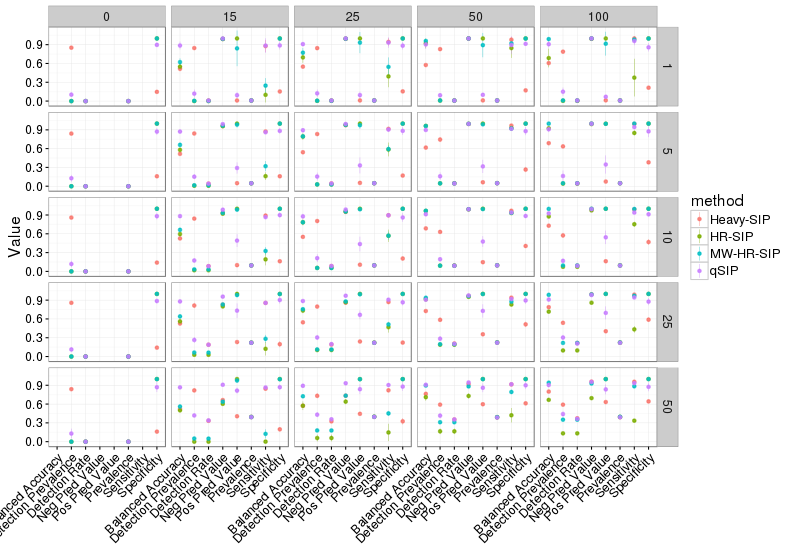

In [269]:
%%R -w 800 -h 550
# summarize by SIPSim rep & library rep
df_byClass.s = df_byClass %>%
    group_by(method, percIncorp, percTaxa, variables) %>%
    summarize(mean_value = mean(values, na.rm=TRUE),
              sd_value = sd(values, na.rm=TRUE))

# plotting
ggplot(df_byClass.s, aes(variables, mean_value, color=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )

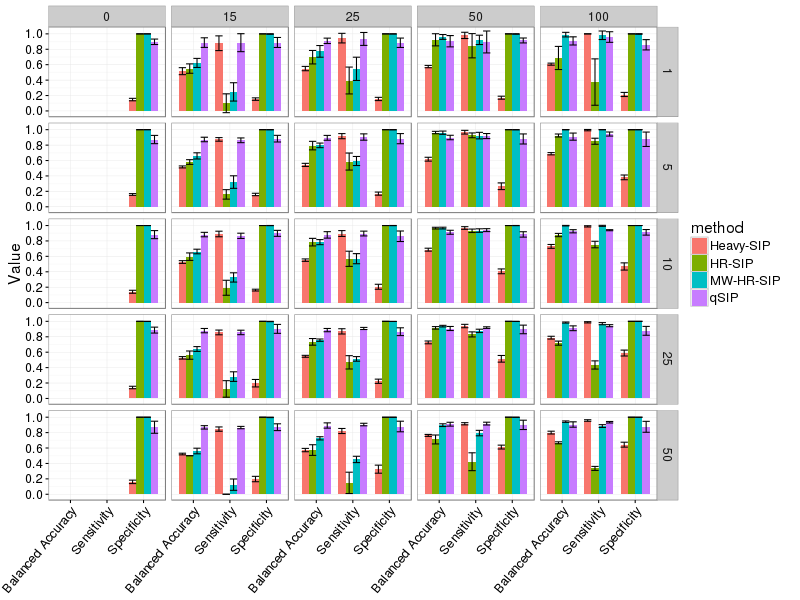

In [270]:
%%R -w 800 -h 600
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) 

# plotting
ggplot(df_byClass.s.f, aes(variables, mean_value, fill=method,
                         ymin=mean_value-sd_value,
                         ymax=mean_value+sd_value)) +
    #geom_pointrange(alpha=0.8, size=0.2) +
    geom_bar(stat='identity', position='dodge', width=0.8) +
    geom_errorbar(stat='identity', position='dodge', width=0.8) +
    scale_y_continuous(breaks=seq(0, 1, 0.2)) +
    labs(y='Value') +
    facet_grid(percTaxa ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=50, hjust=1)
    )

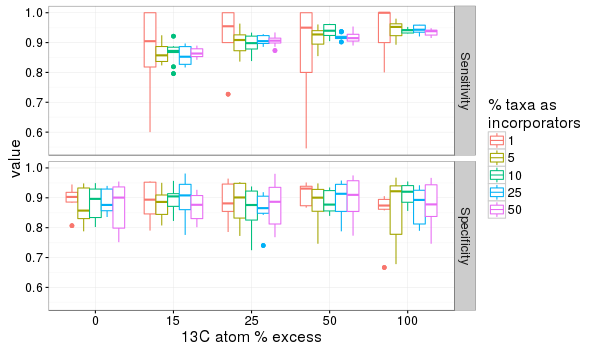

In [272]:
%%R -w 600 -h 350
# check of qSIP
df_byClass.f = df_byClass %>%
    filter(method=='qSIP', 
           variables %in% c('Specificity', 'Sensitivity')) %>%
    mutate(percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           percIncorp = percIncorp %>% as.character,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric))


# plotting
ggplot(df_byClass.f, aes(percIncorp, values, color=percTaxa)) +
    geom_boxplot() +
    scale_color_discrete('% taxa as\nincorporators') +
    labs(x='13C atom % excess', y='value') +
    facet_grid(variables ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

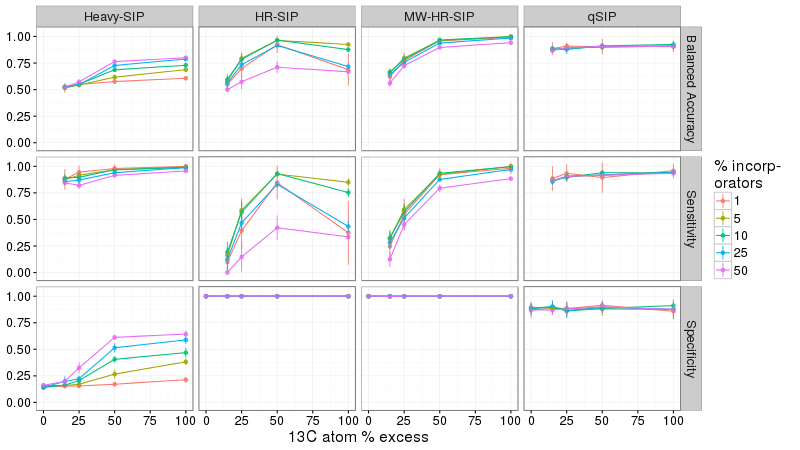

In [273]:
%%R -w 800 -h 450
# summarize by SIPSim rep & library rep
vars = c('Balanced Accuracy', 'Sensitivity', 'Specificity')
df_byClass.s.f = df_byClass.s %>%
    filter(variables %in% vars) %>%
    ungroup() %>%
    mutate(percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))


# plotting
p.pnt = ggplot(df_byClass.s.f, aes(percIncorp, mean_value, 
                           color=percTaxa, 
                           group=percTaxa,
                           ymin=mean_value-sd_value,
                           ymax=mean_value+sd_value)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess') +
    facet_grid(variables ~ method) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_blank()
    )
p.pnt 

In [274]:
%%R 
outFile = 'atomIncorp_taxaIncorp_acc.pdf'
ggsave(outFile, p.pnt, width=10, height=5.63)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/atomIncorp_taxaIncorp_acc.pdf 


### Plot number of false positives

* emphasize the issue of specificity

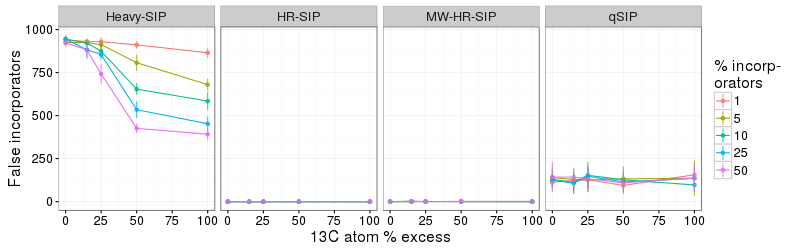

In [328]:
%%R -w 800 -h 250
# theoretical number of taxa
df.ntaxa = data.frame(
    'variables' = rep('Specificity', 3),
    'ntaxa' = c(500, 1100, 2000)
)

df_byClass.j = inner_join(df_byClass, df.ntaxa, c('variables'='variables')) %>%
    mutate(nFP = (1-values) * ntaxa) %>%
    group_by(method, percIncorp, percTaxa, ntaxa) %>%
    summarize(mean_nFP = mean(nFP, na.rm=TRUE),
              sd_nFP = sd(nFP, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(percTaxa = percTaxa %>% as.character,
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric),
           ntaxa = ntaxa %>% as.character) %>%
    filter(ntaxa == 1100)

# plotting
p.FP = ggplot(df_byClass.j, aes(percIncorp, mean_nFP, 
                           color=percTaxa, group=percTaxa,
                           ymin=mean_nFP-sd_nFP,
                           ymax=mean_nFP+sd_nFP)) +
    geom_point(alpha=0.8) +
    geom_linerange(alpha=0.8, size=0.5) +
    geom_line() +
    scale_color_discrete('% incorp-\norators') +
    labs(x='13C atom % excess',
         y='False incorporators') +
    facet_grid( ~ method, scales='free_y') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.FP 

### Combined figure

In [329]:
%%R
g_legend = function(a.gplot){ 
  tmp = ggplot_gtable(ggplot_build(a.gplot)) 
  leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
  legend = tmp$grobs[[leg]] 
  return(legend)
  }
                     
p.leg = g_legend(p.pnt)

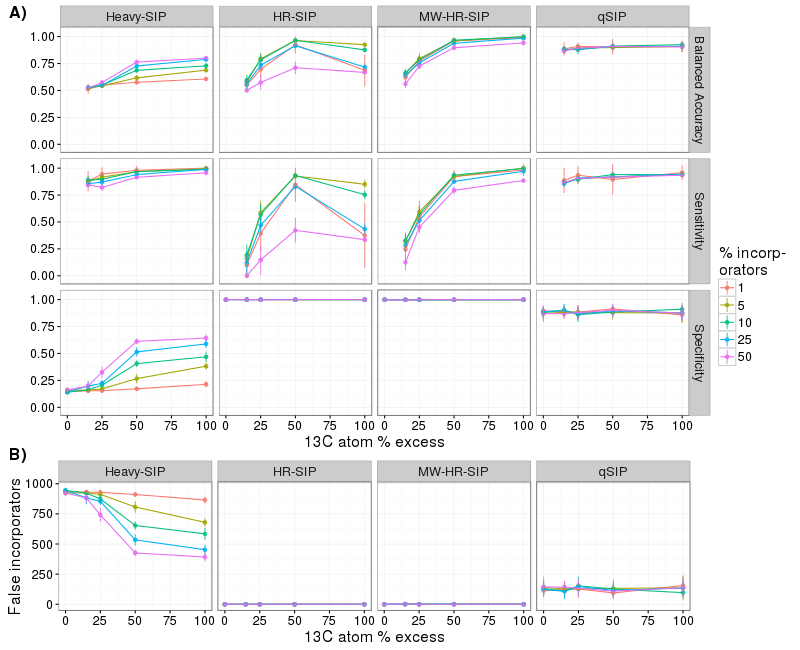

In [354]:
%%R -w 800 -h 650

p.pnt.e = p.pnt + theme(legend.position='none')
p.FP.e = p.FP + theme(legend.position='none')

p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), color='white', fill='white') +
    cowplot::draw_plot(p.pnt.e, 0.03, 0.3, 0.865, 0.7) +
    cowplot::draw_plot(p.FP.e, 0, 0, 0.87, 0.3) +
    cowplot::draw_plot(p.leg, 0.90, 0.38, 0.08, 0.3) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.32))
p.comb

In [356]:
%%R
outFile = 'atomIncorp_taxaIncorp_acc-FP.pdf'
ggsave(outFile, p.comb, width=10, height=8.5)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/atomIncorp_taxaIncorp_acc-FP.pdf 


***

# atom excess estimates

## qSIP

In [423]:
atomX_files = glob.glob('*/*/*/*_atom.txt')
len(atomX_files)

250

In [424]:
%%R -i atomX_files

df_atomX = list()
for(F in atomX_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_atomX[[F]] = tmp
}

df_atomX = do.call(rbind, df_atomX)
rownames(df_atomX) = 1:nrow(df_atomX)
df_atomX %>% head(n=3)

                                 taxon  control treatment      BD_diff
1       Acaryochloris_marina_MBIC11017       NA  1.735000           NA
2 Acetobacter_pasteurianus_IFO_3283-03 1.711478  1.730446  0.018967947
3       Acetobacterium_woodii_DSM_1030 1.706348  1.698732 -0.007615707
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1         NA         NA               NA           NA                   NA
2  0.7834275   308.0796         317.6634     311.4940            0.3523052
3  0.7219901   308.0491         317.6636     306.6742           -0.1414111
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1          NA           NA         50       50   7
2   0.3287802   0.37572502         50       50   7
3  -0.2018421  -0.07953983         50       50   7
                              file
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt
3 OTU_abs1e9_PCR_sub_qSIP_atom.txt


In [425]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

250

In [426]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon percIncorp percTaxa   rep median_true_BD_shift
                          (fctr)      (chr)    (chr) (chr)                (dbl)
1 Acaryochloris_marina_MBIC11017          0        1     1                    0
2 Acaryochloris_marina_MBIC11017          0        1    10                    0
3 Acaryochloris_marina_MBIC11017          0        1     2                    0


In [427]:
%%R
# table join
df_atomX %>% nrow %>% print

df.j = left_join(df_atomX, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'percTaxa'='percTaxa',
                                       'rep'='rep')) %>%
   filter(!is.na(BD_diff)) %>%
   mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
          true_atom_fraction_excess = median_true_BD_shift / 0.036,
          atom_fraction_excess = ifelse(is.na(atom_CI_low), 0, atom_fraction_excess))

df.j %>% nrow %>% print
df.j %>% head(n=3)

[1] 286750
[1] 272007
                                 taxon  control treatment       BD_diff
1 Acetobacter_pasteurianus_IFO_3283-03 1.711478  1.730446  0.0189679469
2       Acetobacterium_woodii_DSM_1030 1.706348  1.698732 -0.0076157075
3    Acetohalobium_arabaticum_DSM_5501 1.700596  1.699750 -0.0008456435
  control_GC control_MW treatment_max_MW treatment_MW atom_fraction_excess
1  0.7834275   308.0796         317.6634     311.4940           0.35230520
2  0.7219901   308.0491         317.6636     306.6742          -0.14141112
3  0.6531156   308.0149         317.6638     307.8618          -0.01569748
  atom_CI_low atom_CI_high percIncorp percTaxa rep
1  0.32878016  0.375725017         50       50   7
2 -0.20184210 -0.079539834         50       50   7
3 -0.03989405  0.007993522         50       50   7
                              file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_qSIP_atom.txt                0.018              TRUE
2 OTU_abs1e9_PCR_sub_qSIP_atom.txt    

In [428]:
%%R
# free memory
df_shift = df_atomX = NULL

# saving dataframe (if needed)
df.j.qSIP = df.j 

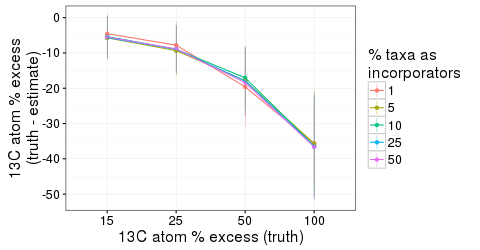

In [429]:
%%R -h 250 
# difference between true and estimated
df.j.dis.qSIP = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa, true_incorporator) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric)) %>%
    filter(true_incorporator == TRUE)
   
# plotting
ggplot(df.j.dis.qSIP, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    geom_line() +
    scale_color_discrete('% taxa as\nincorporators') +
    labs(x='13C atom % excess (truth)', 
         y='13C atom % excess\n(truth - estimate)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Chk: qSIP sensitivity/specificty

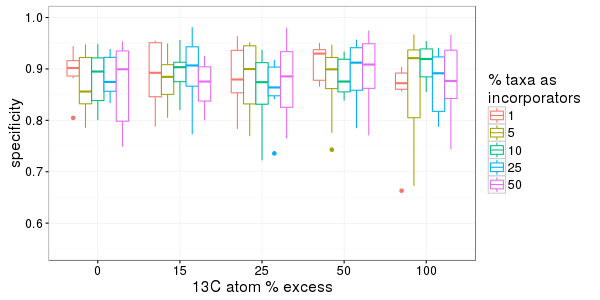

In [430]:
%%R -w 600 -h 300

df.j.s = df.j %>% 
    #filter(!is.na(atom_CI_low)) %>%
    mutate(pred_incorp = ifelse(atom_CI_low > 0, TRUE, FALSE),
           pred_incorp = ifelse(is.na(pred_incorp), FALSE, pred_incorp),
           FP = ifelse((pred_incorp==TRUE & true_incorporator==FALSE), 1, 0),
           TP = ifelse((pred_incorp==TRUE & true_incorporator==TRUE), 1, 0),
           FN = ifelse((pred_incorp==FALSE & true_incorporator==TRUE), 1, 0),
           TN = ifelse((pred_incorp==FALSE & true_incorporator==FALSE), 1, 0)) %>%
    group_by(percIncorp,percTaxa,rep) %>%
    summarize(n_FP = sum(FP),
              n_TP = sum(TP),
              n_FN = sum(FN),
              n_TN = sum(TN),
              n = n(),
              specificity = n_TN / (n_TN+n_FP),
              sensitivity = n_TP / (n_TP+n_FN)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% as.character,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric))

# plotting
ggplot(df.j.s, aes(percIncorp, specificity, color=percTaxa)) +
    geom_boxplot() +
    scale_y_continuous(limits=c(0.55, 1)) +
    scale_color_discrete('% taxa as\nincorporators') +
    labs(x='13C atom % excess', y='specificity') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## deltaBD

In [431]:
dBD_files = glob.glob('*/*/*/*_dBD.txt')
len(dBD_files)

250

In [432]:
%%R -i dBD_files

df_dBD = list()
for(F in dBD_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_dBD[[F]] = tmp
}

df_dBD = do.call(rbind, df_dBD)
rownames(df_dBD) = 1:nrow(df_dBD)
df_dBD %>% head(n=3)

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.742474          1.738216
2 Acetobacter_pasteurianus_IFO_3283-03        1.715840          1.732343
3       Acetobacterium_woodii_DSM_1030        1.713479          1.695490
  stdev_CM_control stdev_CM_treatment     delta_BD percIncorp percTaxa rep
1      0.000000000        0.003112361 -0.004257915         50       50   7
2      0.003060431        0.003842456  0.016502104         50       50   7
3      0.006503952        0.001694501 -0.017989063         50       50   7
                        file
1 OTU_abs1e9_PCR_sub_dBD.txt
2 OTU_abs1e9_PCR_sub_dBD.txt
3 OTU_abs1e9_PCR_sub_dBD.txt


In [433]:
BDshift_files = glob.glob('*/*/*/BD-shift_stats.txt')
len(BDshift_files)

250

In [434]:
%%R -i BDshift_files

df_shift = list()
for(F in BDshift_files){
    tmp = read.delim(F, sep='\t') 
    FF = strsplit(F, '/') %>% unlist
    tmp$percIncorp = FF[1]
    tmp$percTaxa = FF[2]
    tmp$rep = FF[3]
    tmp$file = FF[4]
    df_shift[[F]] = tmp
}

df_shift = do.call(rbind, df_shift)
rownames(df_shift) = 1:nrow(df_shift)

df_shift = df_shift %>%
    filter(library %in% c(2,4,6)) %>%
    group_by(taxon, percIncorp, percTaxa, rep) %>%
    summarize(median = median(median)) %>%
    ungroup() %>%
    rename('median_true_BD_shift' = median)

df_shift %>% head(n=3)

Source: local data frame [3 x 5]

                           taxon percIncorp percTaxa   rep median_true_BD_shift
                          (fctr)      (chr)    (chr) (chr)                (dbl)
1 Acaryochloris_marina_MBIC11017          0        1     1                    0
2 Acaryochloris_marina_MBIC11017          0        1    10                    0
3 Acaryochloris_marina_MBIC11017          0        1     2                    0


In [435]:
%%R
df.j = inner_join(df_dBD, df_shift, c('taxon' = 'taxon',
                                       'percIncorp'='percIncorp',
                                       'percTaxa'='percTaxa',
                                       'rep'='rep')) %>%
    filter(!is.na(delta_BD)) %>%
    mutate(true_incorporator = ifelse(median_true_BD_shift > 0.002, TRUE, FALSE),
           true_atom_fraction_excess = median_true_BD_shift / 0.036,
           atom_fraction_excess = delta_BD / 0.036)
df.j %>% head(n=3)

                                 taxon mean_CM_control mean_CM_treatment
1       Acaryochloris_marina_MBIC11017        1.742474          1.738216
2 Acetobacter_pasteurianus_IFO_3283-03        1.715840          1.732343
3       Acetobacterium_woodii_DSM_1030        1.713479          1.695490
  stdev_CM_control stdev_CM_treatment     delta_BD percIncorp percTaxa rep
1      0.000000000        0.003112361 -0.004257915         50       50   7
2      0.003060431        0.003842456  0.016502104         50       50   7
3      0.006503952        0.001694501 -0.017989063         50       50   7
                        file median_true_BD_shift true_incorporator
1 OTU_abs1e9_PCR_sub_dBD.txt                0.018              TRUE
2 OTU_abs1e9_PCR_sub_dBD.txt                0.018              TRUE
3 OTU_abs1e9_PCR_sub_dBD.txt                0.000             FALSE
  true_atom_fraction_excess atom_fraction_excess
1                       0.5           -0.1182754
2                       0.5           

In [436]:
%%R
# free memory
df_shift = df_dBD = NULL
# saving dataframe (if needed)
df.j.dBD = df.j

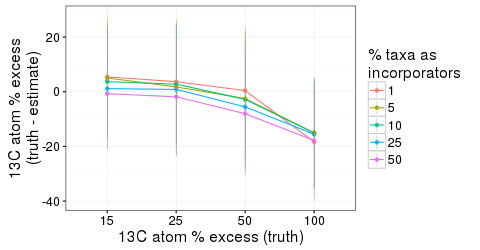

In [437]:
%%R -h 250 
# difference between true and estimated
df.j.dis.dBD = df.j %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100) %>%
    group_by(percIncorp, percTaxa, true_incorporator) %>%
    summarize(mean_delta_excess = mean(delta_excess),
              sd_delta_excess = sd(delta_excess)) %>%
    ungroup() %>%
    mutate(percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric)) %>%
    filter(true_incorporator == TRUE)
   
# plotting
ggplot(df.j.dis.dBD, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_pointrange(alpha=0.8, size=0.2) +
    geom_line() +
    scale_color_discrete('% taxa as\nincorporators') +
    labs(x='13C atom % excess (truth)', y='13C atom % excess\n(truth - estimate)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## qSIP+deltaBD

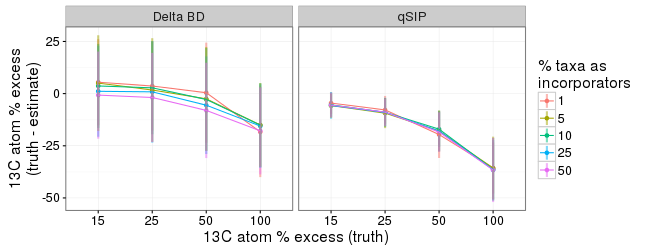

In [518]:
%%R -w 650 -h 250
df.jj = rbind(df.j.dis.qSIP %>% mutate(method='qSIP'),
              df.j.dis.dBD %>% mutate(method='Delta BD'))

# plotting
p.comb = ggplot(df.jj, aes(percIncorp, mean_delta_excess, 
                      color=percTaxa, group=percTaxa,
                      ymin=mean_delta_excess-sd_delta_excess,
                     ymax=mean_delta_excess+sd_delta_excess)) +
    geom_point() +
    geom_linerange(alpha=0.5, size=1) +
    geom_line() +
    scale_color_discrete('% taxa as\nincorporators') +
    labs(x='13C atom % excess (truth)', y='13C atom % excess\n(truth - estimate)') +
    facet_grid(. ~ method) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.comb

### Density plots

In [519]:
%%R
df.jj = rbind(df.j.qSIP %>% 
                  dplyr::select(atom_fraction_excess, true_atom_fraction_excess, percIncorp,
                                true_incorporator, percTaxa) %>%
                  mutate(method='qSIP'),
              df.j.dBD %>% 
                  dplyr::select(atom_fraction_excess, true_atom_fraction_excess, percIncorp,
                                true_incorporator, percTaxa) %>%
                  mutate(method='Delta BD')) %>%
    filter(percTaxa == '10',
           true_incorporator==TRUE,
           atom_fraction_excess!=0) %>%
    mutate(delta_excess = atom_fraction_excess * 100 - true_atom_fraction_excess * 100,
           percIncorp = percIncorp %>% reorder(percIncorp %>% as.numeric),
           percTaxa = percTaxa %>% reorder(percTaxa %>% as.numeric), 
           atom_perc_excess = atom_fraction_excess * 100,
           true_atom_perc_excess = true_atom_fraction_excess * 100) 

df.jj %>% head(n=3)

  atom_fraction_excess true_atom_fraction_excess percIncorp true_incorporator
1            0.3329134                       0.5         50              TRUE
2            0.3518201                       0.5         50              TRUE
3            0.3171024                       0.5         50              TRUE
  percTaxa method delta_excess atom_perc_excess true_atom_perc_excess
1       10   qSIP    -16.70866         33.29134                    50
2       10   qSIP    -14.81799         35.18201                    50
3       10   qSIP    -18.28976         31.71024                    50


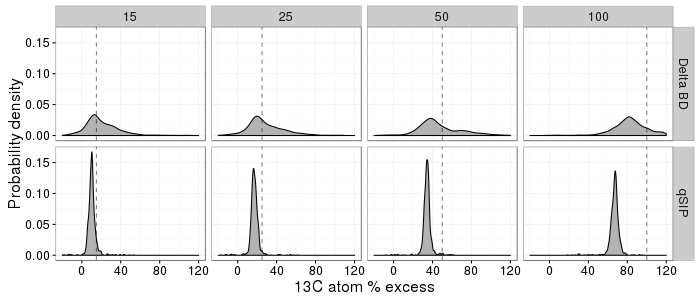

In [520]:
%%R -w 700 -h 300

tmp = df.jj %>%
    dplyr::select(true_atom_perc_excess, percIncorp, method) %>%
    distinct(percIncorp, method) 

p.dens = ggplot(df.jj, aes(atom_perc_excess)) +
    geom_density(fill='grey70') +
    geom_vline(data=tmp, aes(xintercept=true_atom_perc_excess), linetype='dashed', alpha=0.5) +
    scale_x_continuous(limits=c(-20, 120)) +
    labs(x='13C atom % excess', y='Probability density') +
    facet_grid(method ~ percIncorp) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p.dens

### Combined plot

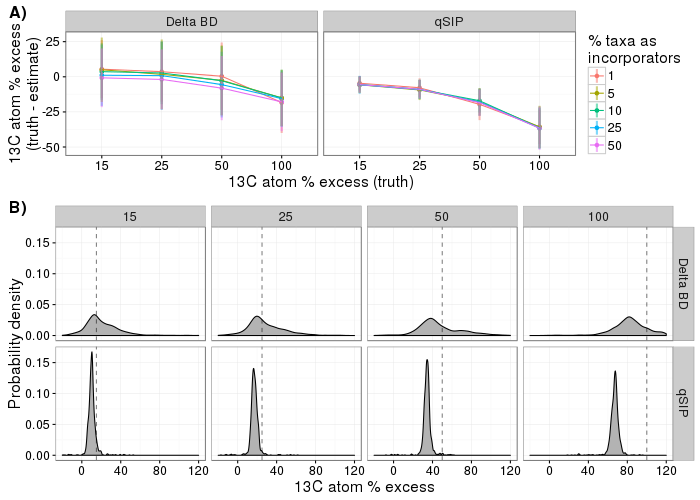

In [521]:
%%R -w 700 -h 500

p.comb2 = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), color='white', fill='white') +
    cowplot::draw_plot(p.comb, 0, 0.61, 1, 0.38) +
    cowplot::draw_plot(p.dens, 0, 0, 1, 0.60) +
    cowplot::draw_plot_label(c('A)', 'B)'), c(0, 0), c(1, 0.61))
p.comb2

In [522]:
%%R
outFile = 'atomIncorp_taxaIncorp_qSIP-dBD.pdf'
ggsave(outFile, p.comb2, width=10, height=7.15)
cat('File written:', file.path(getwd(), outFile), '\n')

File written: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/atomIncorp_taxaIncorp_qSIP-dBD.pdf 


***

# --re-run--

* for all simulations that died due to a memory error

In [93]:
import glob

## Function for detecting missing/empty files

In [194]:
def find_missing_files(filepath, empty_cut=10000):
    # directories
    dirpath = os.path.split(filepath)[0]
    chk = os.path.join(buildDir, dirpath) + '/'
    D = set([os.path.split(x)[0] for x in glob.glob(chk)])
    
    # files
    chk = os.path.join(buildDir, filepath)
    F = glob.glob(chk)
    
    # check for missing files
    Fd = set([os.path.split(f)[0] for f in F])
    missing = D - Fd    
    print 'Union length: {}'.format(len(D | Fd))
    print 'Number of missing: {}'.format(len(missing))

    # check for empty files
    empties = [os.path.split(f)[0] for f in F if os.path.getsize(f) < empty_cut]
    print 'Number of empties: {}'.format(len(empties))
    
    # ret
    return {'missing' : list(missing), 'empty' : empties}
    
find_missing_files('*/*/*/OTU_abs1e9.txt')    

Union length: 200
Number of missing: 0
Number of empties: 1


{'empty': ['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6'],
 'missing': []}

## Finding all SIPSim pipeline incompletes

In [195]:
pipeline_me = find_missing_files('*/*/*/OTU_abs1e9.txt')   

Union length: 200
Number of missing: 0
Number of empties: 1


In [196]:
pipeline_me

{'empty': ['/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6'],
 'missing': []}

In [197]:
# rerunning 
exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_SIPSim-pipeline.sh'
exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSim_pipeline.log'
!$exe 
%pushnote SIPSim pipeline rerun complete

#-- SIPSim pipeline --#
# Adding diffusion
# Adding DBL contamination; abundance-weighted smearing
# Adding isotope incorporation to BD distribution
# Simulating an OTU table
# Simulating PCR
# Subsampling from the OTU table (simulating sequencing of the DNA pool)
# Making a wide-formatted table
# Making metadata (phyloseq: sample_data)


In [205]:
exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_SIPSim-summary.sh'
exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSim_summary.log'
!$exe 
%pushnote pipeline summary rerun complete

In [202]:
# exe = '/home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/SIPSimRun_HRSIP.sh'
# exe += ' 2> /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6/HR-SIP.log'
# !$exe 
# %pushnote HRSIP rerun complete

In [203]:
pipeline_me = find_missing_files('*/*/*/OTU_abs1e9.txt')  

Union length: 200
Number of missing: 0
Number of empties: 1


## Finding all HR-SIP incompletes

In [231]:
HRSIP_me = find_missing_files('*/*/*/OTU_abs1e9_PCR_sub_filt_DESeq2') 

Union length: 200
Number of missing: 75
Number of empties: 0


In [238]:
def run_HRSIP(dirpath):
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_HRSIP.sh', 'HR-SIP.log')
    !$cmd

for FL in HRSIP_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_HRSIP(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/1
Square root transformation
Wisconsin double standardization
Run 0 stress 0.1306591 
Run 1 stress 0.1303777 
... New best solution
... procrustes: rmse 0.007102089  max resid 0.0444321 
Run 2 stress 0.1948695 
Run 3 stress 0.1306245 
... procrustes: rmse 0.007451967  max resid 0.04495998 
Run 4 stress 0.130682 
... procrustes: rmse 0.006855106  max resid 0.04451128 
Run 5 stress 0.2935093 
Run 6 stress 0.2017967 
Run 7 stress 0.1302226 
... New best solution
... procrustes: rmse 0.003597437  max resid 0.01851154 
Run 8 stress 0.1835123 
Run 9 stress 0.130223 
... procrustes: rmse 4.537866e-05  max resid 0.0001128968 
*** Solution reached
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/5/3
Square root transformation
Wisconsin double standardization
Run 0 stress 0.08853476 
Run 1 stress 0.08856917 
... procrustes: rmse 0.001831047  max resid 0.01022147 
Run 2 stress 0

In [239]:
HRSIP_me = find_missing_files('*/*/*/OTU_abs1e9_PCR_sub_filt_DESeq2') 

Union length: 200
Number of missing: 0
Number of empties: 0


## Finding all qSIP pipeline incompletes

In [212]:
qSIP_me = find_missing_files('*/*/*/*qSIP_atom.txt')  

Union length: 200
Number of missing: 80
Number of empties: 1


### re-running qSIP

In [ ]:
def run_qSIP(dirpath):
    #cmd = os.path.join(dirpath, 'SIPSimRun_qSIP.sh')
    #log = os.path.join(dirpath, 'qSIP.log')
    cmd = 'cd {}; perl -pi -e "s/--np 10/--np 20/" {}'.format(dirpath, 'SIPSimRun_qSIP.sh')
    !$cmd
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_qSIP.sh', 'qSIP.log')
    !$cmd

for FL in qSIP_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_qSIP(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/100/25/6


In [ ]:
%pushnote qSIP rerun complete

### re-running cMtx

In [228]:
cMtx_me = find_missing_files('*/*/*/qSIP-cMtx_overall.txt', empty_cut=200)  

Union length: 200
Number of missing: 82
Number of empties: 0


In [242]:
def run_cMtx(dirpath):
    cmd = 'cd {}; {} 2> {}'.format(dirpath, './SIPSimRun_cMtx.sh', 'cMtx.log')
    !$cmd

for FL in cMtx_me.values():
    for D in FL:
        print 'Processing: {}'.format(D)
        run_cMtx(D)

Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/1
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/5/3
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/3
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/2
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/5
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/4
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/7
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/6
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/9
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/50/8
Processing: /home/nick/notebook/SIPSim/dev/bac_genome1147/atomIncorp_taxaIncorp/25/25/9
Processing: /home/nick/notebook/S

In [243]:
cMtx_me = find_missing_files('*/*/*/qSIP-cMtx_overall.txt', empty_cut=200)  

Union length: 200
Number of missing: 0
Number of empties: 0


In [244]:
%pushnote cMtx rerun complete